<a href="https://colab.research.google.com/github/AnnaVitali/plantRecognition/blob/develop/plantRecognition_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Riconoscimento delle piante

Il problema che si vuole andare a risolvere consiste nel riconosce le diverse tipologie di piante a partire da un'immagine della foglia.

# Download training set

url del dataset di riferimento: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset 

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

Saving kaggle.json to kaggle.json
ref                                                             title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ahsan81/hotel-reservations-classification-dataset               Hotel Reservations Dataset                         480KB  2023-01-04 12:50:31           8372        290  1.0              
googleai/musiccaps                                              MusicCaps                                          793KB  2023-01-25 09:25:48           1561        165  0.9411765        
themrityunjaypathak/most-subscribed-1000-youtube-channels       Most Subscribed 1000 Youtube Channels               28KB  2023-01-21 14:42:05           1998         66  1.0              
nitishsharma01/olympics-124-yea

In [ ]:
! unzip new-plant-diseases-dataset.zip

# Import

In [4]:
import os
import glob
import re
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import random
import shutil
from PIL import Image
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from ipywidgets import interact, fixed
import ipywidgets as widgets
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import img_to_array
from keras.layers.reshaping.flatten import Flatten
from keras.models import Model
from keras.layers import Dense
from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
%tensorflow_version 2.x

!pip uninstall -y h5py
!pip install h5py==2.10.0

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Successfully uninstalled h5py-3.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 53.3 MB/s eta 0:00:00


# Utilies

In [6]:
class_names = ['Apple', 'Blueberry', 'Cherry', 'Corn', 'Grape', 'Orange', 'Peach', 'Pepper,', 'Potato', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Tomato']

In [7]:
def organize_data(data_folder_path, data_folder):
  class_folder_path_list = glob.glob(data_folder_path + '/*/')
  if not os.path.exists(data_folder):
    os.mkdir(data_folder)
  count = 0;
  for class_folder_path in class_folder_path_list:
        class_folder_path=class_folder_path.replace('\\','/')
        folder_label=os.path.basename(class_folder_path.split('_', 1)[0])
        destination_folder = data_folder + '/'+ folder_label
        if not os.path.exists(destination_folder):
          os.mkdir(destination_folder)
        for image_file_path in glob.glob(class_folder_path+'/*'):
            image_file_path=image_file_path.replace('\\','/')
            shutil.copy(image_file_path, destination_folder + '/' + str(count) + '.jpg')
            count = count + 1

# Caricamento dataset

Il dateset contiene in tutto 87K immagini RGB di foglie con malattie e sane riferite, a 14 diverse tipologie di piante:

- è diviso secondo un rapporto 70/30 in dati del training set e dati del test set;
- le diverse immagini sono ragruppate in cartelle per le classi corrispondenti.

In [8]:
db_path_train = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
db_path_valid = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
train_data_folder = '/content/train'
valid_data_folder = '/content/valid'

organize_data(db_path_train, train_data_folder)
organize_data(db_path_valid, valid_data_folder)

In [19]:
train = tf.keras.utils.image_dataset_from_directory(
    train_data_folder,
    labels="inferred",
    seed=1337,
    image_size=(224, 224)
)

valid = tf.keras.utils.image_dataset_from_directory(
    valid_data_folder,
    validation_split = 0.3,
    subset="training",
    labels="inferred",
    seed=1337,
    image_size=(224, 224)
)

test = tf.keras.utils.image_dataset_from_directory(
    valid_data_folder,
    validation_split = 0.3,
    subset="validation",
    labels="inferred",
    seed=1337,
    image_size=(224, 224)
)


Found 70295 files belonging to 14 classes.
Found 17572 files belonging to 14 classes.
Using 12301 files for training.
Found 17572 files belonging to 14 classes.
Using 5271 files for validation.


# Visualizzazione immagini

Le classi del problema considerato sono 14: Apple, Blueberry, Cherry, Corn, Grape, Orange, Peach, Pepper, Potato, Raspberry, Soybean, Squash, Strawberrry e Tomato.

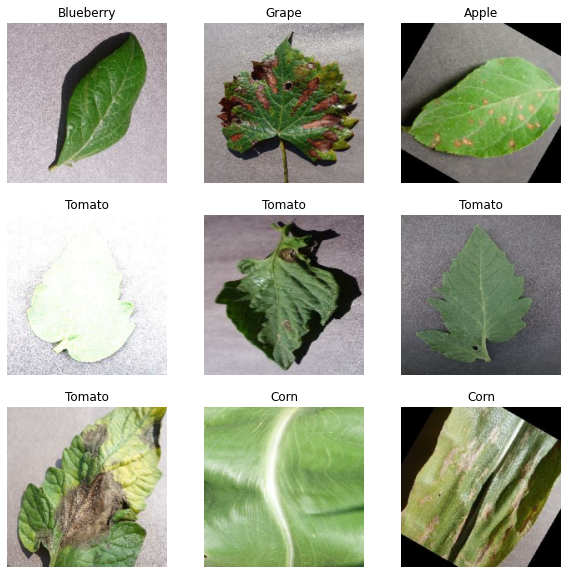

In [20]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Definizione del modello

Come modello di partenza si è deciso di utilizzare VGG16 addestrata con i pesi di **imagenet**:
- la dimensione delle immagini di input è 224 x 244 x 3

In [21]:
pre_trained_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
print(pre_trained_model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

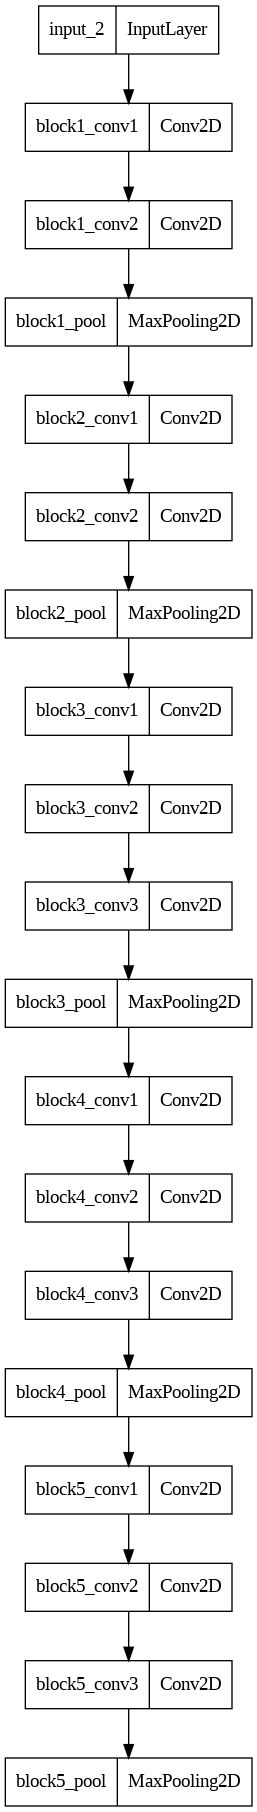

In [22]:
plot_model(pre_trained_model, to_file='vgg.png')

## Fine tuning

A partire dal modello VGG16 preaddestrato, è stato definito un nuovo modello in questo modo:
- aggiungendo un nuovo livello *Fully Connected*, al modello preaddestrato, adattando il numero di classi con quelle del nostro problema;
- come funzione di attivazione di questo livello è stato utilizzata *soft_max*.

Per l'addestramento del modello è stato utilizzato come ottimizzatore *adam* e come funzione di loss *sparse_categorical_crossentropy*.

In [24]:
for layer in pre_trained_model.layers:
  layer.trainable = False

model = keras.models.Sequential()
model.add(pre_trained_model)
model.add(Flatten())
model.add(Dense(len(class_names), activation='softmax'))

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"]
)

print('Inputs: %s' % model.inputs)
print('Outputs: %s' % model.outputs)

model.summary()

Inputs: [<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'vgg16_input')>]
Outputs: [<KerasTensor: shape=(None, 14) dtype=float32 (created by layer 'dense_2')>]
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 14)                351246    
                                                                 
Total params: 15,065,934
Trainable params: 351,246
Non-trainable params: 14,714,688
_________________________________________________________________


## Addestramento del modello

Per l'addestramento del modello sono state utilizzate 3 epoche, in quanto si è visto che già con questo numero si ottengono un buon risultato per la **loss** e per l'**accuratezza**.

In [25]:
history = model.fit(train, validation_data = valid, epochs = 3)

Epoch 1/3
2197/2197 [==============================] - 420s 190ms/step - loss: 1.4576 - accuracy: 0.9543 - val_loss: 1.1439 - val_accuracy: 0.9767
Epoch 2/3
2197/2197 [==============================] - 418s 190ms/step - loss: 0.6114 - accuracy: 0.9866 - val_loss: 1.7403 - val_accuracy: 0.9746
Epoch 3/3
2197/2197 [==============================] - 421s 191ms/step - loss: 0.5117 - accuracy: 0.9900 - val_loss: 1.2203 - val_accuracy: 0.9840


In [26]:
#Saving our model
filepath="model.h5"
model.save(filepath)

## Visualizzazione grafici accuratezza e loss

Come si può vedere dalle immagini, l'accuratezza:
- sul *training set* aumenta notevolmente fin dalla prima epoca, per poi rallentare dalla seconda epoca in poi;
- sul *validation set* invece, si abbassa leggermente fino alla seconda epoca per poi aumentare.

Per quanto riguarda la *loss*:
- per il *training set* tende a diminuire man mano che le epoche aumentano;
- per il *validation set*, la loss aumenta durante la prima epoca per poi diminuire nella seconda.

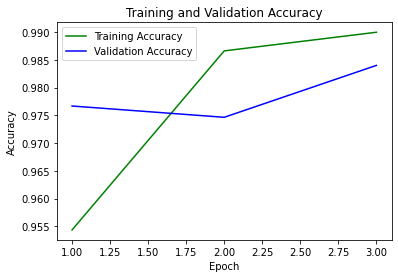

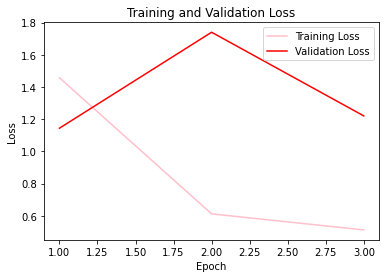

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()

#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Predizioni sul test set

A questo punto è possibile sottomettere alla rete il *test set* e valutare le prestazioni ottenute:
- l'accuratezza ottenuta è del 99%;
- la classe in cui sono stati ottenuti i risultati peggiori è stata la Blueberry con una precisione di 96%;
  - questo perchè le immagini di questa classe sono presenti con quantità minore rispetto alle altre nel test set ed è stato commesso un errore di classificazione;
- le classi in cui sono stati ottenuti i risultati migliori sono Cherry, Grape, Potato, Soybean e Squash con una precisione di 100%;
  - probabilmente perchè le foglie di queste tipologie di piante risultano essere facilmente distinguibili dalle altre.

In [28]:
predictions = np.array([])
labels =  np.array([])
for x, y in tqdm(test):
  pred =  model.predict(x, verbose=False).argmax(axis=-1)
  predictions = np.concatenate([predictions,pred])
  labels = np.concatenate([labels, y])

  0%|          | 0/165 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       Apple       0.99      0.97      0.98       600
   Blueberry       0.96      0.99      0.98       123
      Cherry       1.00      0.98      0.99       278
        Corn       0.99      1.00      1.00       548
       Grape       1.00      0.99      1.00       528
      Orange       0.99      0.99      0.99       166
       Peach       0.98      0.98      0.98       263
     Pepper,       0.98      0.98      0.98       304
      Potato       1.00      0.93      0.96       436
   Raspberry       0.99      1.00      1.00       130
     Soybean       1.00      0.97      0.99       149
      Squash       1.00      0.99      1.00       129
  Strawberry       0.99      0.99      0.99       268
      Tomato       0.97      0.99      0.98      1349

    accuracy                           0.98      5271
   macro avg       0.99      0.98      0.99      5271
weighted avg       0.98      0.98      0.98      5271



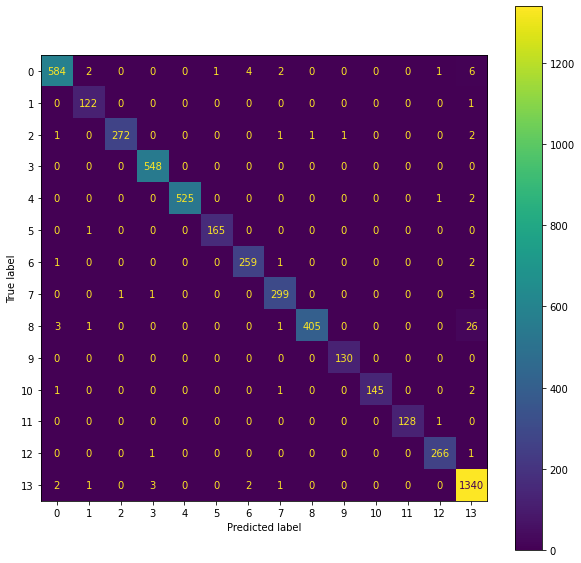

In [29]:
print(classification_report(labels, predictions, target_names=class_names))

matrix = confusion_matrix(labels, predictions)
diagonal = matrix.diagonal()/matrix.sum(axis=1)

# Mostriamo la matrice di confusione
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(len(class_names))))
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

# Conclusioni

Complessivamente i risultati ottenuti sono molto buoni. 
Problematiche della soluzione adottata:
- la *loss* sul validation set non ha un andamento stabile;
- se si diminuisce le dimensioni delle immagini, le prestazioni calano, sebbene non di molto.

Possibili modifiche:
- adottare un'altra funzione per misurare la *loss*;
- modificare l'ottimizzatore;
- aumentare le epoche.